In [4]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# Part 3

### Question 1:

For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

### Answer:

* Get hour column from Yellow_Taxi data and group them to count the number of trips. 
* Sort them by frequency
* Select the first row to answer the question

In [8]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:////Users/rishabhsalwan/Downloads/Project Data/Project.db', echo=False)

In [ ]:
rush_hour = engine.execute("""select strftime("%H",tpep_pickup_datetime) as Hours, count(strftime("%H",tpep_pickup_datetime)) as Frequency 
                    from Yellow_Taxi
                    group by Hours
                    order by Frequency DESC
                    """).fetchall()

rush_hour

[('19', 12312),
 ('18', 11976),
 ('20', 11341),
 ('21', 10920),
 ('22', 10769),
 ('14', 9973),
 ('17', 9940),
 ('12', 9583),
 ('23', 9547),
 ('13', 9541),
 ('15', 9294),
 ('09', 9195),
 ('11', 9112),
 ('08', 8918),
 ('10', 8806),
 ('16', 8322),
 ('00', 7721),
 ('07', 6940),
 ('01', 5760),
 ('02', 4317),
 ('06', 3979),
 ('03', 3114),
 ('04', 2175),
 ('05', 1917)]

In [ ]:
print(f"The most busy hour of the day for yellow taxi cabs was {rush_hour[0][0]}:00 hours")

The most busy hour of the day for yellow taxi cabs was 19:00 hours


### Question 2:

For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.


### Answer:

* Get pickup weekday column from Yellow_Taxi data and group them to count the trips. 
* Sort them by frequency
* Select the first row to answer the question

In [ ]:
from datetime import datetime

uber_rush_day = engine.execute("""select strftime("%w",pickup_datetime) as Day, count(strftime("%w",pickup_datetime)) as Frequency 
                    from Uber_new
                    group by Day
                    order by Frequency DESC
                    """).fetchall()

uber_rush_day


[('5', 29894),
 ('6', 29360),
 ('4', 29090),
 ('3', 28101),
 ('2', 27292),
 ('0', 25603),
 ('1', 24438)]

In [ ]:
import calendar
print(f"The most busy day of the week for uber was {calendar.day_name[int(uber_rush_day[0][0])]}")


The most busy day of the week for uber was Saturday


### Question 3:

What is the 95% percentile of distance traveled for all hired trips during July 2013?

### Answer :

* Get the distance column from both Yellow_Taxi and Uber_new data and attach them using union all which gives us all hired trips
* Sort them by percentile 
* Filter for July 2013
* Filter it for less than 95% and consequently get the first row to answer the question

In [ ]:
All_cab_95_distance = engine.execute("""select trip_distance, percentile
from (select tpep_pickup_datetime, trip_distance, 
Percent_rank() over( order by trip_distance) as percentile
from (
select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
from Yellow_Taxi
union all
select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
from Uber_new
)
where strftime("%Y",tpep_pickup_datetime)=="2013" and strftime("%m",tpep_pickup_datetime)=="07")
where percentile <= 0.95
order by percentile DESC
limit 1
""").fetchall()

print(f"The the 95% percentile of distance traveled for all hired trips during July 2013 was {All_cab_95_distance[0][0]} miles")

The the 95% percentile of distance traveled for all hired trips during July 2013 was 8.38 miles


### Question 4:

What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?


### Answer:

* Get all hired data by combining Yellow taxi and uber
* Filter for Year 2009
* Group the data by days and calculate the average distance per day
* Sort them by frequency of hired rides (highest to lowest) 
* Select the first 10 rows to answer the question

In [ ]:
top10_days = engine.execute("""
select strftime("%Y-%m-%d",tpep_pickup_datetime) as Days, count(strftime("%Y-%m-%d",tpep_pickup_datetime)) as Frequency,
avg(trip_distance) as Average_distance
from (
select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
from Yellow_Taxi
union all
select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
from Uber_new
)
where strftime("%Y",tpep_pickup_datetime)=="2009"
group by Days
order by Frequency DESC
limit 10
""").fetchall()
top10_days

[('2009-12-11', 251, 2.0751065095953773),
 ('2009-10-23', 216, 2.267915773293144),
 ('2009-02-20', 216, 2.2160982528197746),
 ('2009-12-05', 215, 2.1170163633900745),
 ('2009-09-25', 215, 2.722113473963468),
 ('2009-04-03', 213, 2.1394537676911334),
 ('2009-12-18', 210, 2.118910318609523),
 ('2009-01-31', 210, 1.9300007260958372),
 ('2009-06-05', 209, 2.202113229215441),
 ('2009-08-14', 208, 2.5353721638001256)]

### Question 5:

Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

### Answer:

* Get the date column from Yellow_Taxi and Uber_new data and attach them using union all 
* Sort the wind data by the average wind speed for each day (from Hight to Low) 
* Get the top 10 windiest days in 2014 from the daily_weather table
* Group the trip data by days and number of trips for the day
* Filter the trips data for the top 10 days of highest wind speed in 2014
* Select and output the number of trips in each of the first 10 windiest rows

In [ ]:
top10_windy_days = engine.execute("""
select strftime("%Y-%m-%d", tpep_pickup_datetime), count(strftime("%Y-%m-%d", tpep_pickup_datetime))
from (
select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
from Yellow_Taxi
union all
select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
from Uber_new
)
where strftime("%Y-%m-%d", tpep_pickup_datetime) in (select strftime("%Y-%m-%d", DATE) as Days_wind 
from Weather_daily
where strftime("%Y", DATE)=="2014"
order by DailyAverageWindSpeed DESC
limit 10)
group by strftime("%Y-%m-%d", tpep_pickup_datetime)
""").fetchall()

top10_windy_days

[('2014-01-02', 62),
 ('2014-01-03', 41),
 ('2014-01-07', 77),
 ('2014-02-13', 63),
 ('2014-03-13', 104),
 ('2014-03-26', 96),
 ('2014-03-29', 107),
 ('2014-11-02', 1381),
 ('2014-12-07', 73),
 ('2014-12-08', 77)]

### Question 5:

During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

### Answer

* Get all trips data, filter it for Hurrican Sandy days
* Get all hourly weather data filter it for Hurrican Sandy days
* Group the trip data for each hour of the selected time period to get the number of rides
* Join the trip and weather data on the day-hour collumn. 
* Output the day-hour windspeed, precipitation and the number of trips 

In [ ]:
weather_per_hour = engine.execute(""" select Hours_weather, HourlyPrecipitation, HourlyWindSpeed, Trips
from(select strftime("%Y-%m-%d %H", DATE) as Hours_weather, HourlyPrecipitation, HourlyWindSpeed
from Weather_hourly
where strftime("%Y-%m-%d", DATE)<="2012-11-06" and strftime("%Y-%m-%d", DATE)>="2012-10-22") as t2
left join (select strftime("%Y-%m-%d %H", tpep_pickup_datetime) as Hours_trips, count(strftime("%Y-%m-%d %H", tpep_pickup_datetime)) as Trips
from (
select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
from Yellow_Taxi
union all
select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
from Uber_new
)
where strftime("%Y-%m-%d", tpep_pickup_datetime)<="2012-11-06" and strftime("%Y-%m-%d", tpep_pickup_datetime)>="2012-10-22"
group by strftime("%Y-%m-%d %H", tpep_pickup_datetime)) as t1
on Hours_trips = Hours_weather
""").fetchall()
weather_per_hour

[('2012-10-22 00', '0.00', 7.0, 2),
 ('2012-10-22 01', '0.00', 5.0, None),
 ('2012-10-22 02', '0.00', 7.0, 1),
 ('2012-10-22 03', '0.00', 0.0, 1),
 ('2012-10-22 04', '0.00', 0.0, None),
 ('2012-10-22 05', '0.00', 0.0, 1),
 ('2012-10-22 06', '0.00', 5.0, 3),
 ('2012-10-22 07', '0.00', 3.0, 5),
 ('2012-10-22 08', '0.00', 3.0, 1),
 ('2012-10-22 09', '0.00', 5.0, 5),
 ('2012-10-22 12', '0.00', 11.0, 5),
 ('2012-10-22 14', '0.00', 7.0, 1),
 ('2012-10-22 15', '0.00', 6.0, 1),
 ('2012-10-22 16', '0.00', 3.0, 6),
 ('2012-10-22 17', '0.00', 7.0, 4),
 ('2012-10-22 18', '0.00', 5.0, 8),
 ('2012-10-22 19', '0.00', 5.0, 2),
 ('2012-10-22 20', '0.00', 3.0, 4),
 ('2012-10-22 21', '0.00', 0.0, 1),
 ('2012-10-22 22', '0.00', 3.0, 6),
 ('2012-10-22 23', '0.00', 3.0, None),
 ('2012-10-23 12', '0.01', 0.0, 1),
 ('2012-10-23 19', '0.01', 0.0, 2),
 ('2012-10-23 20', '0.02', 0.0, 8),
 ('2012-10-23 21', '0.01', 5.0, 4),
 ('2012-10-23 22', '0.01', 0.0, 6),
 ('2012-10-23 23', '0.01', 5.0, 3),
 ('2012-10-24 00',

# Part 4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Question 1:

Create an appropriate visualization for the first query/question in part 3.

### Answer:

In [ ]:
def trips_hour():
    rush_hour = engine.execute("""select strftime("%H",tpep_pickup_datetime) as Hours, count(strftime("%H",tpep_pickup_datetime)) as Frequency 
                        from Yellow_Taxi
                        group by Hours
                        order by Hours ASC""").fetchall()
    hour = [f"{i[0]}:00" for i in rush_hour]
    trips = [i[1] for i in rush_hour]

    plt.figure(figsize=[15,5], dpi=100)
    plt.bar(hour, trips, color="yellow")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Trips")
    plt.title("Most Popular Time of the Day for Yellow Taxi")
    return plt.show()

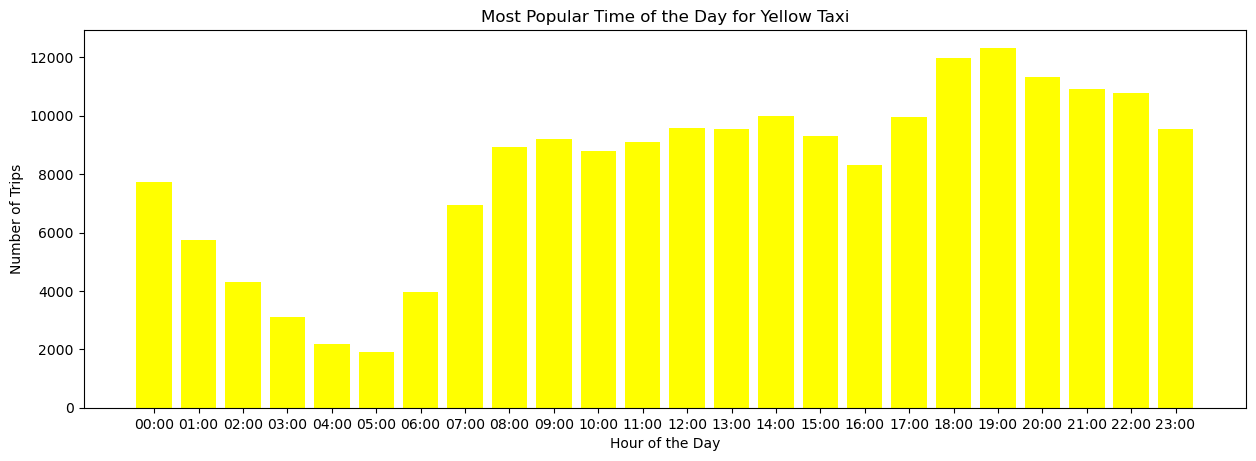

In [ ]:
trips_hour()

### Question 2

Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.

### Answer 

In [ ]:
def distance_month():
    month_distance = engine.execute("""
    select strftime("%m",tpep_pickup_datetime) as Month, avg(trip_distance) as Average_distance
    from (
    select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
    from Yellow_Taxi
    union all
    select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
    from Uber_new
    )
    group by Month
    """).fetchall()
    month_name = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "Novemeber","December"]
    months = [month_name[int(i[0])-1] for i in month_distance]
    trip_distance = [i[1] for i in month_distance]
    all_month_distance = engine.execute("""
    select strftime("%m",tpep_pickup_datetime) as Month, trip_distance
    from (
    select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
    from Yellow_Taxi
    union all
    select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
    from Uber_new
    )
    """).fetchall()
    month_data = pd.DataFrame(data=all_month_distance, columns=["Month", "Distance"])
    month_data = month_data.groupby("Month").agg(["mean","count","std"])
    mean = month_data["Distance"]["mean"]
    std = month_data["Distance"]["std"]
    month_data["lower"] = month_data["Distance"]["mean"] - 1.64*(month_data["Distance"]["std"]/np.sqrt(month_data["Distance"]["count"]))
    month_data["upper"] = month_data["Distance"]["mean"] + 1.64*(month_data["Distance"]["std"]/np.sqrt(month_data["Distance"]["count"]))
    month_data["Diff"]= month_data["upper"] - month_data["lower"]
    plt.figure(figsize=[15,10], dpi=100)
    plt.bar(months, mean, yerr = month_data["Diff"]/2, capsize=10)
    plt.ylim([2.2,2.7])
    plt.xlabel("Month of the Year")
    plt.ylabel("Average Distance Travelled (miles)")
    plt.title("Average Distance for each Month")
    return plt.show()

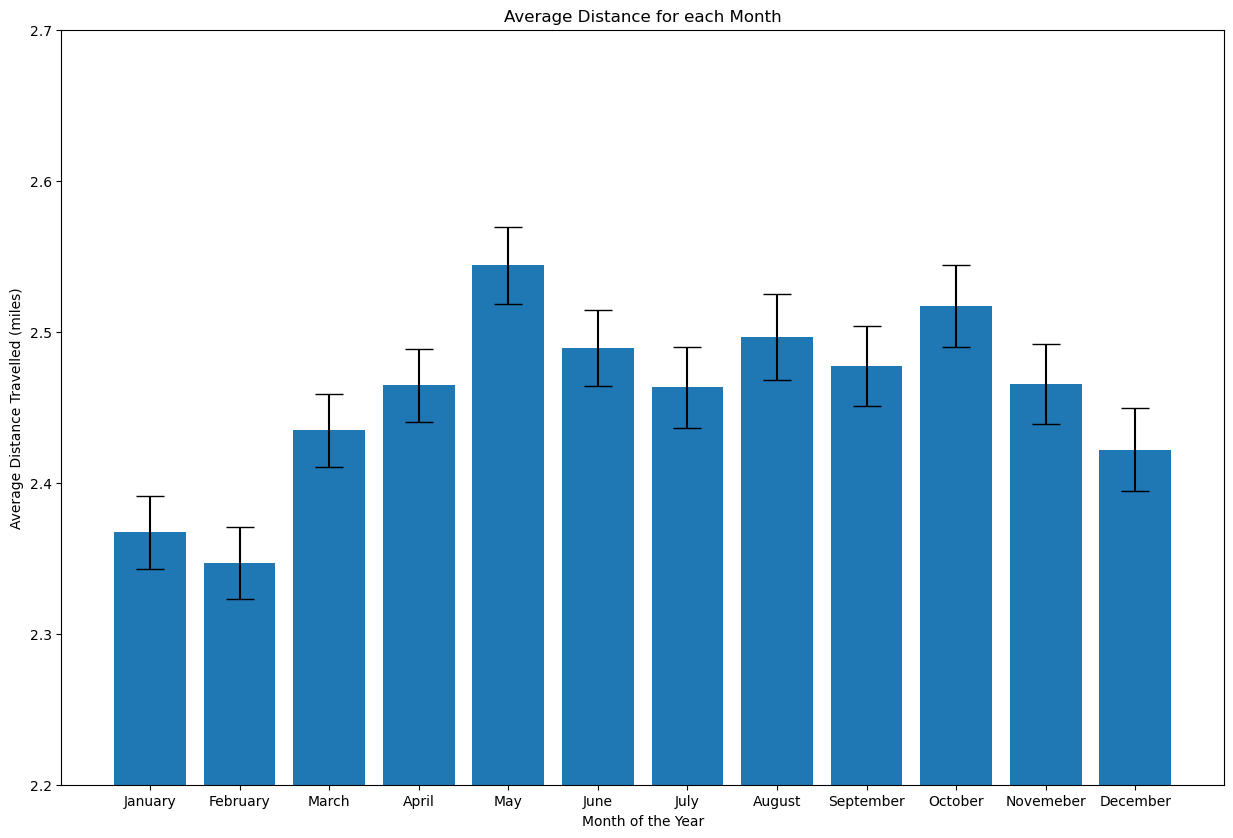

In [ ]:
distance_month()

### Question 3

Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.


### Answer:

In [ ]:
def airport_week_traffic():
    lat1_lga = 40.764378
    lat2_lga = 40.788817
    long1_lga = -73.890103
    long2_lga = -73.852680

    long1_ewr, lat1_ewr, long2_ewr, lat2_ewr = -74.224983,40.661716,-74.143272,40.723671
    long1_jfk, lat1_jfk, long2_jfk, lat2_jfk =-73.828542,40.619587,-73.733957,40.675462
    
    day_counts_lga = engine.execute(f"""select strftime("%w",tpep_pickup_datetime) as Day,count(strftime("%w",tpep_pickup_datetime)) as Frequency 
                    from(
                    select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
                    from Yellow_Taxi
                    union all
                    select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
                    from Uber_new
                    )
                    where dropoff_longitude>={long1_lga} and dropoff_longitude<={long2_lga} and dropoff_latitude>={lat1_lga} and dropoff_latitude<={lat2_lga}
                    group by Day
                    """).fetchall()
    day_counts_ewr = engine.execute(f"""select strftime("%w",tpep_pickup_datetime) as Day,count(strftime("%w",tpep_pickup_datetime)) as Frequency 
                        from(
                        select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
                        from Yellow_Taxi
                        union all
                        select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
                        from Uber_new
                        )
                        where dropoff_longitude>={long1_ewr} and dropoff_longitude<={long2_ewr} and dropoff_latitude>={lat1_ewr} and dropoff_latitude<={lat2_ewr}
                        group by Day
                        """).fetchall()
    day_counts_jfk = engine.execute(f"""select strftime("%w",tpep_pickup_datetime) as Day,count(strftime("%w",tpep_pickup_datetime)) as Frequency 
                        from(
                        select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
                        from Yellow_Taxi
                        union all
                        select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance
                        from Uber_new
                        )
                        where dropoff_longitude>={long1_jfk} and dropoff_longitude<={long2_jfk} and dropoff_latitude>={lat1_jfk} and dropoff_latitude<={lat2_jfk}
                        group by Day
                        """).fetchall()
    day_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    days = [day_name[int(i)] for i in list(zip(*day_counts_lga))[0]]
    freq_lga = list(zip(*day_counts_lga))[1]
    freq_ewr = list(zip(*day_counts_ewr))[1]
    freq_jfk = list(zip(*day_counts_jfk))[1]

    plt.figure(figsize=[10,5], dpi=100)
    plt.title("Traffic for Airports Near New York for Each Day of the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Number of Drop-offs")
    w= 0.35
    x = np.arange(len(days))
    plt.bar(x-w/2,freq_lga,w/2, label="LaGuardia")
    plt.bar(x,freq_jfk,w/2, label="JFK")
    plt.bar(x+w/2,freq_ewr,w/2, label="Newark")
    plt.xticks(x, days)
    plt.legend()
    return plt.show()

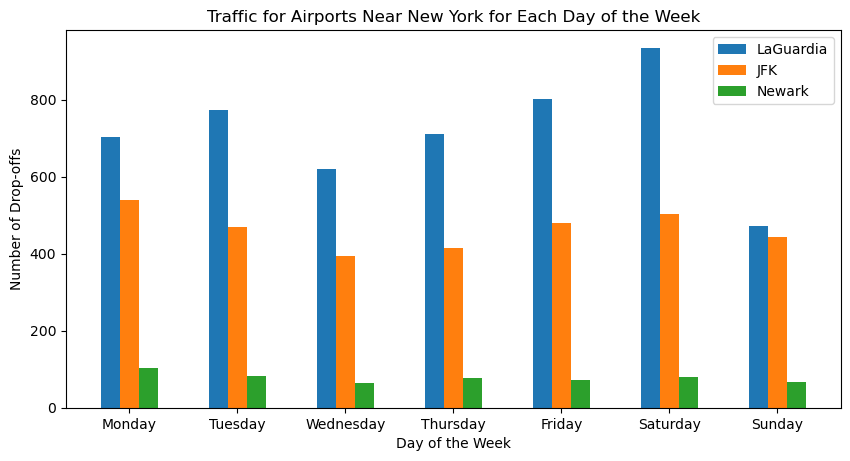

In [ ]:
airport_week_traffic()

### Question 4

Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

### Answer:

In [9]:
def heat_map():
    import pandas as pd
    from keplergl import KeplerGl
    combined_trip_data = engine.execute("""select round(pickup_longitude,3), round(pickup_latitude,3)
                        from (
                        select tpep_pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance, fare_amount
                        from Yellow_Taxi
                        union all
                        select pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance, fare_amount
                        from Uber_new
                        )
                        """).fetchall()
    heat_map_df = pd.DataFrame(data=combined_trip_data, columns=["pickup_longitude","pickup_latitude"])
    heat_grouped = heat_map_df.groupby(["pickup_longitude","pickup_latitude"]).size().reset_index(name='counts')
    map_1 = KeplerGl(height=500)
    map_1.add_data(data = heat_grouped)
    return map_1


In [10]:
heat_map()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

### Question 5

Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.

### Answer:

In [ ]:
def tip_distance():
    tip_distance = engine.execute(f""" select trip_distance, tip_amount
                            from Yellow_Taxi
                            where trip_distance<30 and tip_amount<20
                            """).fetchall()
    distance = list(zip(*tip_distance))[0]
    tip = list(zip(*tip_distance))[1]
    plt.title("Scatter Plot of Tip Amount and Trip Distance")
    plt.scatter(distance, tip)
    plt.ylabel("Tip Amount($)")
    plt.xlabel("Distance (miles)")
    return plt.show()

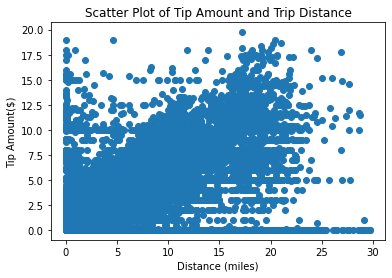

In [ ]:
tip_distance()

### Question 6

Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

### Answer: 

In [ ]:
def tip_precipitation():
    precipitation_data = engine.execute(f""" select strftime("%Y-%m-%d %H",DATE) as Date_hour, HourlyPrecipitation
                            from Weather_hourly
                            where HourlyPrecipitation<0.5
                            """).fetchall()
    Yellow_taxi = engine.execute(f""" select strftime("%Y-%m-%d %H",tpep_pickup_datetime) as Date_hour, tip_amount
                            from Yellow_Taxi
                            """).fetchall()
    prec_df = pd.DataFrame(data=precipitation_data, columns=["Date_hour","HourlyPrecipitation"])
    Yellow_df = pd.DataFrame(data=Yellow_taxi, columns=["Date_hour","tip_amount"])
    df_final = prec_df.merge(Yellow_df.drop_duplicates(subset=["Date_hour"]), how="left", on="Date_hour").dropna()
    #plt.NullLocator()
    plt.figure(figsize=[10,5], dpi=100)
    plt.scatter(df_final["HourlyPrecipitation"],df_final["tip_amount"], color="blue")
    plt.xlabel("Precipitation Level (Inches)")
    plt.xticks(ticks=[0,10,20, 30, 40, 50])
    #plt.gca().xaxis.set_major_locator(ticker.FixedLocator([0,1,5]))
    plt.ylabel("Tip Amount ($)")
    plt.title("Tip Amounts and Precipitation for Yellow Taxi")
    return plt.show()

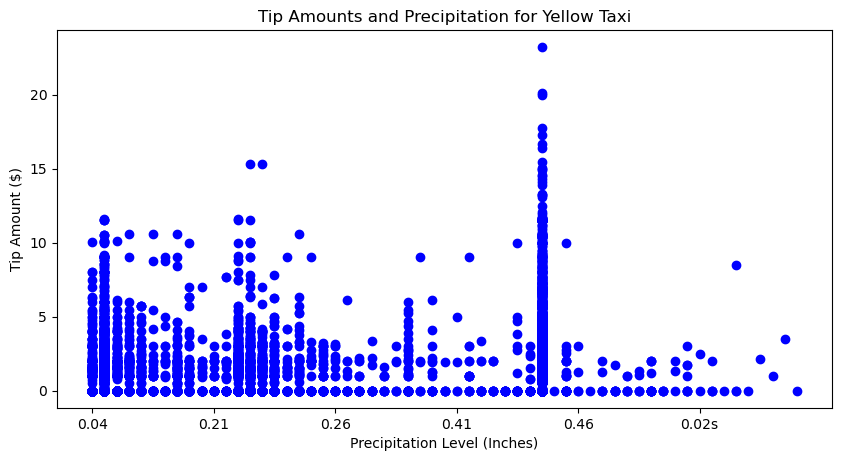

In [ ]:
tip_precipitation()

### Question 7a

Compare uber and yellow taxi yearly average fare per mile:

### Answer:

Observations: 

* Uber more expensive that taxis
* Fares for both vehicles have consistently increased
* The price difference between uber and taxi fares seems to increase with time

In [ ]:
# Compare yearly average fares (fare/km) for taxi and uber
def yellow_uber_fare():
    yellow_taxi = engine.execute(f""" select strftime("%Y",tpep_pickup_datetime) as Year, sum(fare_amount), sum(trip_distance), sum(fare_amount)/sum(trip_distance) 
                            from Yellow_Taxi
                            group by Year
                            """).fetchall()
    uber_taxi = engine.execute(f""" select strftime("%Y",pickup_datetime) as Year, sum(fare_amount), sum(trip_distance), sum(fare_amount)/sum(trip_distance) 
                        from Uber_new
                        group by Year
                        """).fetchall()
    years = list(zip(*yellow_taxi))[0]
    uber_fare = list(zip(*uber_taxi))[-1]
    yellow_fare = list(zip(*yellow_taxi))[-1]
    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure(figsize=[8,5],dpi=100)
    x = np.arange(len(years))
    w=0.35
    plt.bar(x+w/2,uber_fare,w, color="black" ,label="Uber")
    plt.bar(x-w/2,yellow_fare,w, color="yellow" ,label="Yellow")
    plt.xticks(x, years)
    plt.title("Uber and Yellow Taxi Yearly Fare/mile")
    plt.xlabel("Years")
    plt.ylabel("Trip Fare ($/mile)")
    plt.legend()
    return plt.show()


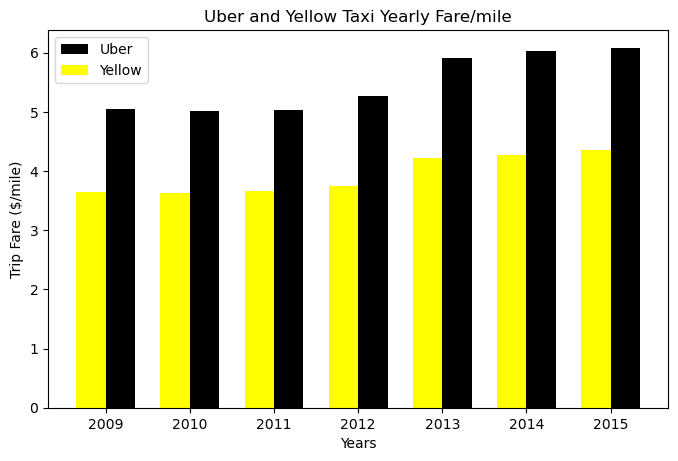

In [ ]:
yellow_uber_fare()

### Question 7b

Compare the difference in the popularity between yellow taxi and uber during the day:

### Answer:

Observations: 

* During afternoon and evening hours yellow taxi is clearly more popular than uber
* On the other hand during other hours the popularity alternates  

In [ ]:
# Popularity of uber vs taxi throughout the day
def popularity_hour():
    import matplotlib.pyplot as plt
    import numpy as np
    yellow_rush_hour = engine.execute("""select strftime("%H",tpep_pickup_datetime) as Hours, count(strftime("%H",tpep_pickup_datetime)) as Frequency 
                            from Yellow_Taxi
                            group by Hours
                            order by Hours ASC""").fetchall()
    uber_rush_hour = engine.execute("""select strftime("%H",pickup_datetime) as Hours, count(strftime("%H",pickup_datetime)) as Frequency 
                        from Uber_new
                        group by Hours
                        order by Hours ASC""").fetchall()
    w=0.35

    hour = [f"{i[0]}:00" for i in yellow_rush_hour]
    x = np.arange(len(hour))
    trips_y = [i[1] for i in yellow_rush_hour]
    trips_u = [i[1] for i in uber_rush_hour]
    y_data = np.array(trips_y)-np.array(trips_u)
    plt.figure(figsize=[15,8], dpi=100)
    plt.bar(x, y_data, w, color=(pd.Series(data=y_data)>0).map({True:"yellow", False:"black"}))
    plt.xlabel("Hour of the Day")
    plt.ylabel("Difference in Number of Trips")
    plt.xticks(x, hour)
    plt.title("Difference in Yellow Taxi and Uber Trips during the Day")
    return plt.show()

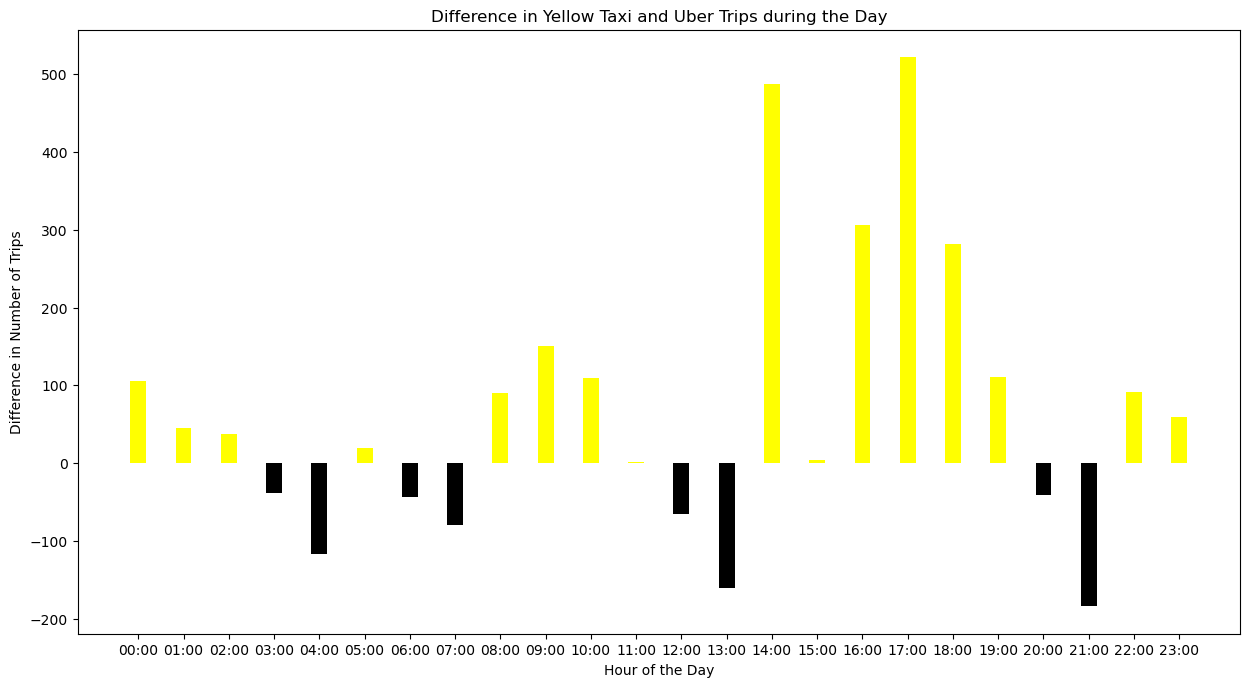

In [ ]:
popularity_hour()

### Question 7c

Compare uber and yellow taxi fare prices for different amount of rain. 

### Answer:

Note:
* Rain is classified in light (< 0.01 inches) , moderate ( <0.3) and heavy(>0.3)

Observations: 

* There are not significant difference in the fare prices due to the rain, hence we can conclude that uber and taxi pricing is not a function of weather.
* Although, the small difference in the fares could possible be because of the decrease in demand as rain increases.  
* Uber price increases for high demand and decreases in lower demand

In [ ]:
# Get daily average precipitation and classify into moderate, light and heavy
def rain_yellow_uber():
    import pandas as pd
    precipitation_data= engine.execute("""select strftime("%Y-%m-%d",DATE) as Date, avg(HourlyPrecipitation) as Precipitation 
                            from Weather_hourly
                            group by strftime("%Y-%m-%d",DATE)""").fetchall()
    prec_df = pd.DataFrame(data=precipitation_data, columns=["Date","Precipitaion"])
    prec_df["Rain"] = pd.cut(prec_df["Precipitaion"], bins=[0,0.01,0.3,10], labels=["light","moderate","heavy"])
    yellow_taxi = engine.execute(f""" select strftime("%Y-%m-%d",tpep_pickup_datetime) as Day, sum(fare_amount)/sum(trip_distance) 
                                from Yellow_Taxi
                                group by Day
                                """).fetchall()
    uber_taxi = engine.execute(f""" select strftime("%Y-%m-%d",pickup_datetime) as Day, sum(fare_amount)/sum(trip_distance) 
                            from Uber_new
                            group by Day
                            """).fetchall()
    yellow_df = pd.DataFrame(data=yellow_taxi,columns=["Date","Yellow_Fare/mile"])
    uber_df = pd.DataFrame(data=uber_taxi,columns=["Date","Uber_Fare/mile"])
    df_1 = prec_df.merge(yellow_df, how="left", on=["Date"])
    df_2 = df_1.merge(uber_df, how="left", on=["Date"]).dropna()
    df_final = df_2.groupby("Rain").mean()[["Yellow_Fare/mile","Uber_Fare/mile"]]
    hour = df_final.index
    w= 0.25
    x = np.arange(len(hour))
    trips_y = df_final["Yellow_Fare/mile"]
    trips_u = df_final["Uber_Fare/mile"]
    plt.figure(figsize=[10,7], dpi=100)
    plt.bar(x+w/2, trips_y, w, color="yellow" ,label="Yellow Taxi")
    plt.bar(x-w/2, trips_u, w, color="black",label="Uber")
    plt.xlabel("Rain Category")
    plt.ylabel("Fare per mile")
    plt.plot(x+w/2,df_final["Yellow_Fare/mile"],"*-", color="black")
    plt.plot(x-w/2,df_final["Uber_Fare/mile"],"*-",color="yellow")
    plt.xticks(x, hour)
    plt.ylim([3,6])
    plt.title("Fare per mile for varying rain intensity")
    plt.legend()
    return plt.show()


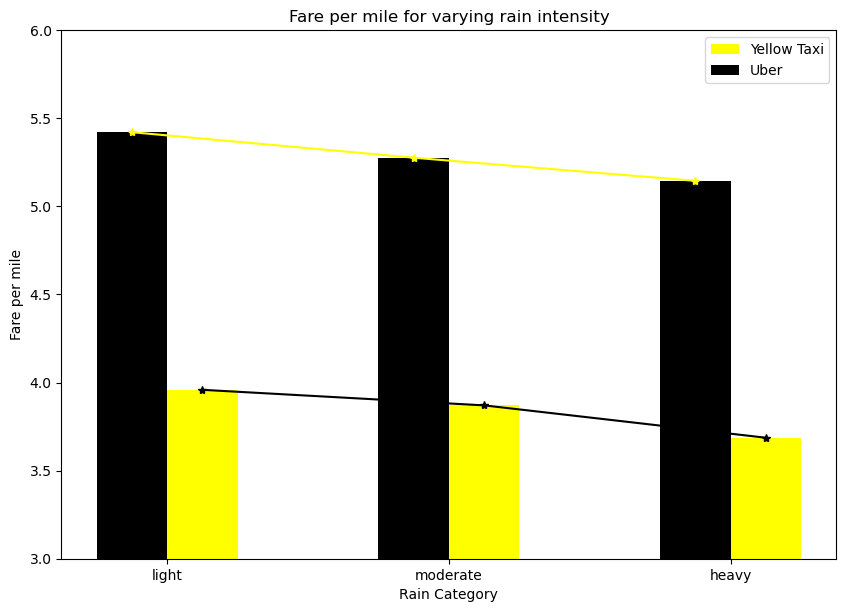

In [ ]:
rain_yellow_uber()